In [492]:
import numpy as np
import torch
from torchvision import transforms
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import TensorDataset
from torch.autograd import Variable 
torch.manual_seed(1)
np.random.seed(1)
import matplotlib.pyplot as plt

# For importing poses
import sys
import os
sys.path.append(os.path.expanduser("/workspace/code/pose-prediction/src/functions"))

In [493]:
from load_poses import get_poses_from_file
dataset_path = "/workspace/data/pose-prediction-odometry/"
RO_se3s,RO_timestamps = get_poses_from_file(dataset_path)

Loading poses from monolithic file...
reading RO_relative_poses_path: /workspace/data/pose-prediction-odometry/ro_relative_poses.monolithic
importing  protobuf.transform.pbSerialisedTransform_pb2
Finished reading 479 poses.


In [494]:
t_x_data = np.zeros(len(RO_timestamps))
t_y_data = np.zeros(len(RO_timestamps))
t_theta_data = np.zeros(len(RO_timestamps))

for i in range(len(RO_timestamps)):
    t_x_data[i] = RO_se3s[i][0,3]
    t_y_data[i] = RO_se3s[i][1,3]
    t_theta_data[i] = np.arccos(RO_se3s[i][0,0])

In [495]:
num_features = 3
num_frames = 4
input_size = num_features * num_frames
output_size = num_features

In [496]:
from model_poses import get_model_pose_prediction_and_error
pred_poses,dim1_data,dim2_data,dim3_data,pred_poses_x,pred_poses_y,pred_poses_theta \
= get_model_pose_prediction_and_error(RO_se3s)

479
478
477


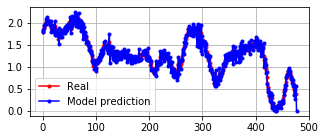

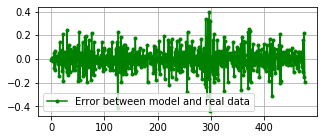

In [497]:
print(len(RO_se3s))
print(len(pred_poses))
print(len(dim1_data))    

plt.figure(figsize=(5,2))
plt.plot(t_x_data[2:],'r.-',label='Real') # cropping first 2 frames here to align plots
plt.plot(pred_poses_x,'b.-',label='Model prediction')
plt.legend()
plt.grid()

plt.figure(figsize=(5,2))
plt.plot(dim1_data,'g.-',label='Error between model and real data')
plt.legend()
plt.grid()

In [498]:
use_toy_data = False
if(use_toy_data):
    from toy_data import make_toy_data
    data_size = 100
    toy_x_model_err,toy_x_data,toy_x_pred = make_toy_data(10,data_size)
    toy_y_model_err,toy_y_data,toy_y_pred = make_toy_data(1,data_size)
    toy_theta_model_err,toy_theta_data,toy_theta_pred = make_toy_data(0.1,data_size)
        
    # hack to allow the rest of the code to remain the same
    t_x_data = toy_x_data
    dim1_data = np.array(toy_x_model_err)
    pred_poses_x = np.array(toy_x_pred)
    t_y_data = toy_y_data
    dim2_data = np.array(toy_y_model_err)
    pred_poses_y = np.array(toy_y_pred)
    t_theta_data = toy_theta_data
    dim3_data = np.array(toy_theta_model_err)
    pred_poses_theta = np.array(toy_theta_pred)

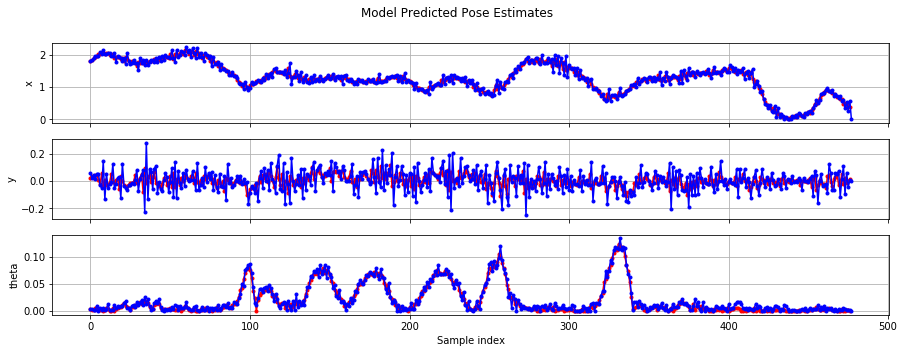

In [499]:
# Plot subfigures
fig,axs = plt.subplots(3,figsize=(15,5))
fig.suptitle('Model Predicted Pose Estimates')
axs[0].plot(t_x_data[2:],'r.-')
axs[0].plot(pred_poses_x,'b.-')
axs[0].set(ylabel = 'x')
axs[1].plot(t_y_data[2:],'r.-')
axs[1].plot(pred_poses_y,'b.-')
axs[1].set(ylabel = 'y')
axs[2].plot(t_theta_data[2:],'r.-')
axs[2].plot(pred_poses_theta,'b.-')
axs[2].set(ylabel = 'theta')
for ax in axs.flat:
    ax.set(xlabel='Sample index')
    ax.grid()

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

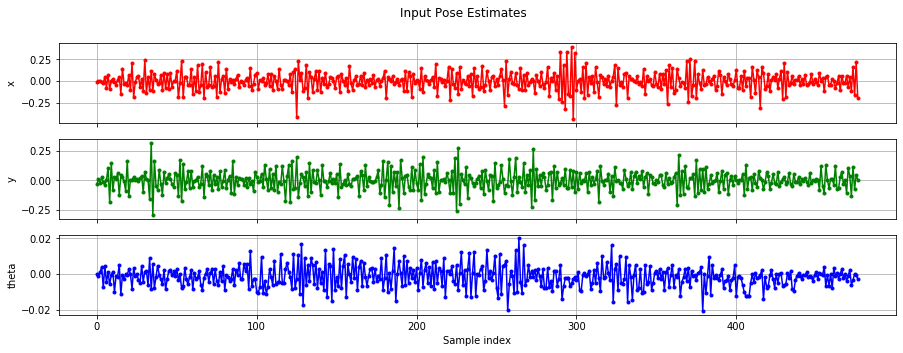

In [500]:
dim1_data_scaled = (dim1_data - dim1_data.mean())/dim1_data.std()
dim2_data_scaled = (dim2_data - dim2_data.mean())/dim2_data.std()
dim3_data_scaled = (dim3_data - dim3_data.mean())/dim3_data.std()

# Plot subfigures
fig,axs = plt.subplots(3,figsize=(15,5))
fig.suptitle('Input Pose Estimates')
axs[0].plot(dim1_data,'r.-')
axs[0].set(ylabel = 'x')
axs[1].plot(dim2_data,'g.-')
axs[1].set(ylabel = 'y')
axs[2].plot(dim3_data,'b.-')
axs[2].set(ylabel = 'theta')
for ax in axs.flat:
    ax.set(xlabel='Sample index')
    ax.grid()

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

In [501]:
from dataset_prep import prepare_data
train_validate_ratio = 0.8
train_ds,valid_ds = \
prepare_data(dim1_data_scaled,dim2_data_scaled,dim3_data_scaled, \
             train_validate_ratio,num_features,num_frames,input_size,output_size)

x_data dimensions: torch.Size([473, 12])
x_train dimensions: torch.Size([378, 12])
x_valid dimensions: torch.Size([95, 12])
y_data dimensions: torch.Size([473, 3])
y_train dimensions: torch.Size([378, 3])
y_valid dimensions: torch.Size([95, 3])


In [502]:
class Pose_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(input_size,output_size)

    def forward(self, xb):
        return self.lin(xb)

epochs = 300
lr = 1e-2
batch_size = 30

model = Pose_Logistic()
loss_func = nn.MSELoss()

from network_helpers import *

train_dl, valid_dl = get_data(train_ds, valid_ds, batch_size)
model = Pose_Logistic()
opt = optim.SGD(model.parameters(), lr=lr)
validation_loss = fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.7909616294660067
1 0.7471875485621
2 0.712645991852409
3 0.6858776148996855
4 0.6640364417904302
5 0.64494683554298
6 0.6297246217727661
7 0.6169162173020212
8 0.6064515035403403
9 0.5965260251572257
10 0.5877688746703299
11 0.5802689006454066
12 0.5732535578702626
13 0.5668994109881552
14 0.5611938363627383
15 0.5564536467978829
16 0.5519810099350778
17 0.5480165042375263
18 0.5444760667650324
19 0.5407499953320152
20 0.5370738396519109
21 0.5338895618915558
22 0.5309502639268574
23 0.5278819172005904
24 0.5253585294673317
25 0.5226782685831973
26 0.520467011552108
27 0.518778775867663
28 0.5165805706852361
29 0.5143152616525951
30 0.5124978376062292
31 0.510719358921051
32 0.5084174244027388
33 0.5068929195404053
34 0.5052503331711418
35 0.5037195039422888
36 0.5016561370146903
37 0.4999920882676777
38 0.498578700580095
39 0.4976791300271687
40 0.4963428503588626
41 0.4949211133153815
42 0.4938941174431851
43 0.4922786809896168
44 0.4911640380558215
45 0.48994871660282735
46 0.48

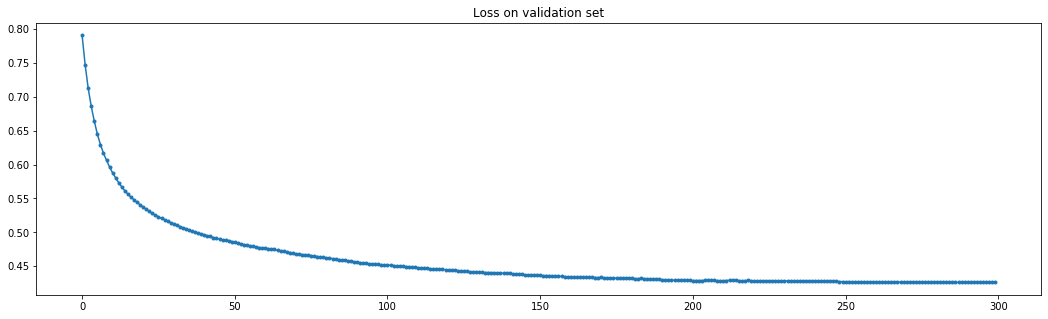

In [503]:
plt.figure(figsize=(18,5))
plt.title("Loss on validation set")
plt.plot(validation_loss,'.-')

In [504]:
from inference import query_at_index
idx = 50
predicted_error_x,predicted_error_y,predicted_error_theta = \
query_at_index(model,dim1_data,dim2_data,dim3_data,num_frames,num_features,idx)

print(predicted_error_x)
print(predicted_error_y)
print(predicted_error_theta)
print('True answer:',dim1_data[idx+num_frames],dim2_data[idx+num_frames],dim3_data[idx+num_frames])
print('...at frame',idx+num_frames)

tensor(-0.1890)
tensor(0.1076)
tensor(0.0015)
True answer: -0.18096067105576386 0.14298519636432735 -0.006489673722131304
...at frame 54


474
477
0.08173024904920247
0.06580946825459189
0.046496012567741225


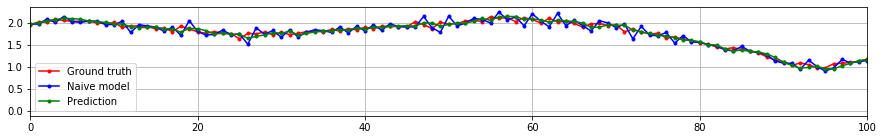

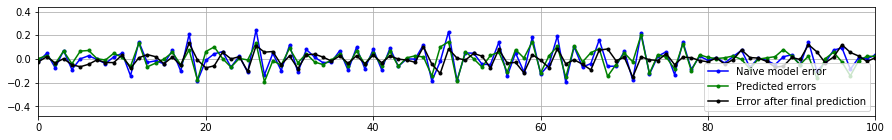

In [505]:
predicted_errors_x = np.zeros(len(dim1_data)-num_frames+1)
final_predictions_x = np.zeros(len(predicted_errors_x))
final_err_x = np.zeros(len(final_predictions_x))

predicted_errors_y = np.zeros(len(dim2_data)-num_frames+1)
final_predictions_y = np.zeros(len(predicted_errors_y))
final_err_y = np.zeros(len(final_predictions_y))

predicted_errors_theta = np.zeros(len(dim3_data)-num_frames+1)
final_predictions_theta = np.zeros(len(predicted_errors_theta))
final_err_theta = np.zeros(len(final_predictions_theta))

print(len(predicted_errors_x))
print(len(dim1_data))

for i in range(len(predicted_errors_x)): 
    predicted_errors_x[i],predicted_errors_y[i],predicted_errors_theta[i] = \
    query_at_index(model,dim1_data,dim2_data,dim3_data,num_frames,num_features,i)

    final_predictions_x[i] = pred_poses_x[i+num_frames] + predicted_errors_x[i]
    final_predictions_y[i] = pred_poses_y[i+num_frames] + predicted_errors_y[i]
    final_predictions_theta[i] = pred_poses_theta[i+num_frames] + predicted_errors_theta[i]
    
# Offset for index at which a valid prediction can be made. Need 4 observations to make a 2-frame prediction, 5 for 3, etc.
pred_offset = 2 + num_frames
# the -1 is because we predict +1 in the future, and so the last prediction has
# no frame from the real data to be compared against
for i in range(len(predicted_errors_x)-1): 
    final_err_x[i] = t_x_data[i+pred_offset] - final_predictions_x[i]
    final_err_y[i] = t_y_data[i+pred_offset] - final_predictions_y[i]
    final_err_theta[i] = t_theta_data[i+pred_offset] - final_predictions_theta[i]

plt.figure(figsize=(15,2))
plt.plot(t_x_data[pred_offset:],'r.-',label='Ground truth')
plt.plot(pred_poses_x[num_frames:],'b.-',label='Naive model')
plt.plot(final_predictions_x,'g.-',label='Prediction')
plt.legend()
plt.grid()
plt.xlim(0,100)

plt.figure(figsize=(15,2))
plt.plot(dim1_data[num_frames:],'b.-',label='Naive model error')
plt.plot(predicted_errors_x,'g.-',label='Predicted errors')
plt.plot(final_err_x,'k.-',label='Error after final prediction')
plt.legend()
plt.grid()
plt.xlim(0,100)

print(np.mean(np.abs(dim1_data)))
print(np.mean(np.abs(predicted_errors_x)))
print(np.mean(np.abs(final_err_x)))

0.06475972133612579
0.053332933755575546
0.04008576772567921


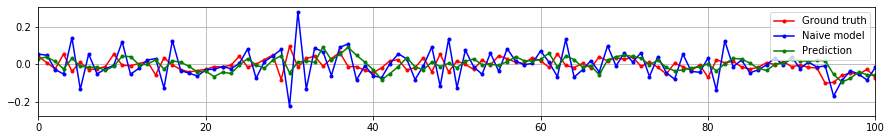

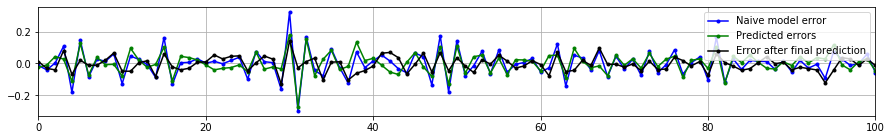

In [506]:
plt.figure(figsize=(15,2))
plt.plot(t_y_data[pred_offset:],'r.-',label='Ground truth')
plt.plot(pred_poses_y[num_frames:],'b.-',label='Naive model')
plt.plot(final_predictions_y,'g.-',label='Prediction')
plt.legend()
plt.grid()
plt.xlim(0,100)

plt.figure(figsize=(15,2))
plt.plot(dim2_data[num_frames:],'b.-',label='Naive model error')
plt.plot(predicted_errors_y,'g.-',label='Predicted errors')
plt.plot(final_err_y,'k.-',label='Error after final prediction')
plt.legend()
plt.grid()
plt.xlim(0,100)

print(np.mean(np.abs(dim2_data)))
print(np.mean(np.abs(predicted_errors_y)))
print(np.mean(np.abs(final_err_y)))

0.004972394620546501
0.0026929421914753185
0.004314557093376545


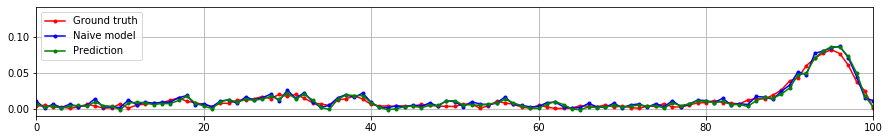

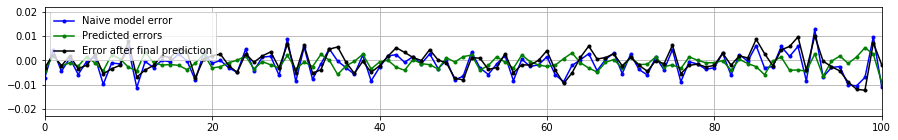

In [507]:
plt.figure(figsize=(15,2))
plt.plot(t_theta_data[pred_offset:],'r.-',label='Ground truth')
plt.plot(pred_poses_theta[num_frames:],'b.-',label='Naive model')
plt.plot(final_predictions_theta,'g.-',label='Prediction')
plt.legend()
plt.grid()
plt.xlim(0,100)

plt.figure(figsize=(15,2))
plt.plot(dim3_data[num_frames:],'b.-',label='Naive model error')
plt.plot(predicted_errors_theta,'g.-',label='Predicted errors')
plt.plot(final_err_theta,'k.-',label='Error after final prediction')
plt.legend()
plt.grid()
plt.xlim(0,100)

print(np.mean(np.abs(dim3_data)))
print(np.mean(np.abs(predicted_errors_theta)))
print(np.mean(np.abs(final_err_theta)))